# Eboss Neural Network on Flux Data

This notebook contains my attempts at training a model on the residual flux data instead of the base flux data. It seems to be doing better.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py

from astropy.io import fits
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import accuracy_score, roc_auc_score, make_scorer
from sklearn import warnings

from IPython.display import SVG
from keras.utils.vis_utils import plot_model

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout, MaxPooling1D, Conv2D, Conv1D, InputLayer, Dropout, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.callbacks import TensorBoard
from keras.utils import np_utils
from keras.wrappers.scikit_learn import KerasClassifier

from Modeling import CrossValidationModeler

Using TensorFlow backend.


# Models

In [2]:
def create_conv_flux_model():
    model = Sequential()
    model.add(InputLayer(batch_input_shape=(None,4639, 1)))
    model.add(Conv1D(filters=64, kernel_size=2,activation= 'relu'))
    model.add(Conv1D(filters=24, kernel_size=2,activation= 'relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(30,activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def create_conv_flux_model_exp():
    model = Sequential()
    model.add(InputLayer(batch_input_shape=(None, 1, 4639, 2)))
    model.add(Conv2D(filters=64, kernel_size=(1,2), activation='relu', data_format='channels_last'))
    #model.add(BatchNormalization())
    #model.add(MaxPooling2D((1,2)))
    model.add(Conv2D(filters=24, kernel_size=(1,2), activation='relu', data_format='channels_last'))
    #model.add(BatchNormalization())
    #model.add(MaxPooling2D((1,2)))
    model.add(Flatten())
    model.add(Dense(30,activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(20, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


def create_complex():
    model = Sequential()
    model.add(InputLayer(batch_input_shape=(None, 4639, 1)))
    
    model.add(Conv1D(filters=64, kernel_size=10))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv1D(filters=32, kernel_size=10))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(MaxPooling1D())
    
    model.add(Conv1D(filters=12, kernel_size=2))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv1D(filters=6, kernel_size=2))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(MaxPooling1D())
    
    model.add(Flatten())
    
    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(.50))
    
    
    model.add(Dense(1024))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(.50))
    
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
    return model

---
## Full Dataset Model

In [3]:
eboss = h5py.File('../../Data/eboss_flux_full+.hdf5')
X, Y = np.array(eboss['flux_values']), np.array(eboss['flux_labels'])
res_flux = np.array(eboss['res_flux_values'])
ivar = np.array(eboss['ivar_flux_values'])

res_flux = np.expand_dims(res_flux, -1)
ivar = np.expand_dims(ivar, -1)
X = np.expand_dims(X, -1)
eboss.close()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(res_flux, Y)

In [55]:
res_flux.shape, ivar.shape, X.shape, Y.shape

((281, 4639, 1), (281, 4639, 1), (281, 4639, 1), (281, 1))

# Initial Testing

In [117]:
mod = create_conv_flux_model()
mod.fit(X_train, y_train, epochs=10, batch_size=8, validation_data=(X_test, y_test))

Train on 210 samples, validate on 71 samples
Epoch 1/10
210/210 [==============================] - 23s 110ms/step - loss: 0.9106 - acc: 0.6810 - val_loss: 0.3382 - val_acc: 0.9014
Epoch 2/10
210/210 [==============================] - 0s 2ms/step - loss: 0.4109 - acc: 0.7333 - val_loss: 0.2612 - val_acc: 0.9577
Epoch 3/10
210/210 [==============================] - 0s 2ms/step - loss: 0.2718 - acc: 0.8619 - val_loss: 0.2187 - val_acc: 0.9577
Epoch 4/10
210/210 [==============================] - 0s 2ms/step - loss: 0.2830 - acc: 0.8095 - val_loss: 0.2160 - val_acc: 0.9577
Epoch 5/10
210/210 [==============================] - 0s 2ms/step - loss: 0.2424 - acc: 0.8667 - val_loss: 0.1807 - val_acc: 0.9577
Epoch 6/10
210/210 [==============================] - 0s 2ms/step - loss: 0.2072 - acc: 0.8619 - val_loss: 0.1630 - val_acc: 0.9437
Epoch 7/10
210/210 [==============================] - 0s 2ms/step - loss: 0.2256 - acc: 0.8619 - val_loss: 0.1404 - val_acc: 0.9859
Epoch 8/10
210/210 [========

### Running 50 folds on the complex version of the nn model.

In [61]:
Keras_eboss_NN_Model = KerasClassifier(create_complex, epochs=10, batch_size=8, verbose=0)
cvm_nn_flux_v2 = CrossValidationModeler(res_flux, Y, Keras_eboss_NN_Model)
cvm_nn_flux_v2.run_cross_val({}, n_splits=50)

Fitting 50 folds for each of 1 candidates, totalling 50 fits
[CV]  ................................................................
[CV]  , precision (no)=1.0, precision (yes)=0.9767441860465116, recall (no)=0.9333333333333333, recall (yes)=1.0, accuracy=0.9824561403508771, roc_auc=0.9666666666666667, f1=0.988235294117647, total=  15.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.1s remaining:    0.0s


[CV]  , precision (no)=0.9333333333333333, precision (yes)=1.0, recall (no)=1.0, recall (yes)=0.9767441860465116, accuracy=0.9824561403508771, roc_auc=0.9883720930232558, f1=0.988235294117647, total=  14.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   29.4s remaining:    0.0s


[CV]  , precision (no)=1.0, precision (yes)=1.0, recall (no)=1.0, recall (yes)=1.0, accuracy=1.0, roc_auc=1.0, f1=1.0, total=  14.7s
[CV]  ................................................................
[CV]  , precision (no)=1.0, precision (yes)=0.9761904761904762, recall (no)=0.9375, recall (yes)=1.0, accuracy=0.9824561403508771, roc_auc=0.96875, f1=0.9879518072289156, total=  15.0s
[CV]  ................................................................
[CV]  , precision (no)=0.9444444444444444, precision (yes)=1.0, recall (no)=1.0, recall (yes)=0.975, accuracy=0.9824561403508771, roc_auc=0.9875, f1=0.9873417721518987, total=  16.1s
[CV]  ................................................................
[CV]  , precision (no)=0.9523809523809523, precision (yes)=1.0, recall (no)=1.0, recall (yes)=0.972972972972973, accuracy=0.9824561403508771, roc_auc=0.9864864864864865, f1=0.9863013698630138, total=  16.8s
[CV]  ................................................................
[CV]  , 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 20.5min finished


,mean_test_precision (no),mean_test_precision (yes),mean_test_recall (no),mean_test_recall (yes),mean_test_accuracy,mean_test_roc_auc,mean_test_f1
Parameters,,,,,,,
{},0.967539,0.981769,0.943719,0.988698,0.977544,0.966208,0.985003


# Generating cross val figure

In [62]:
pd.DataFrame(cvm_nn_flux_v2.last_results).to_csv("complex_model_results.csv")

In [65]:
v2_results = pd.read_csv('complex_model_results.csv').to_dict()

In [66]:
v2_accuracy_list = list(map(lambda x: x[1][0], filter(lambda x: 'accuracy' in x[0] and 'split' in x[0] , v2_results.items())))

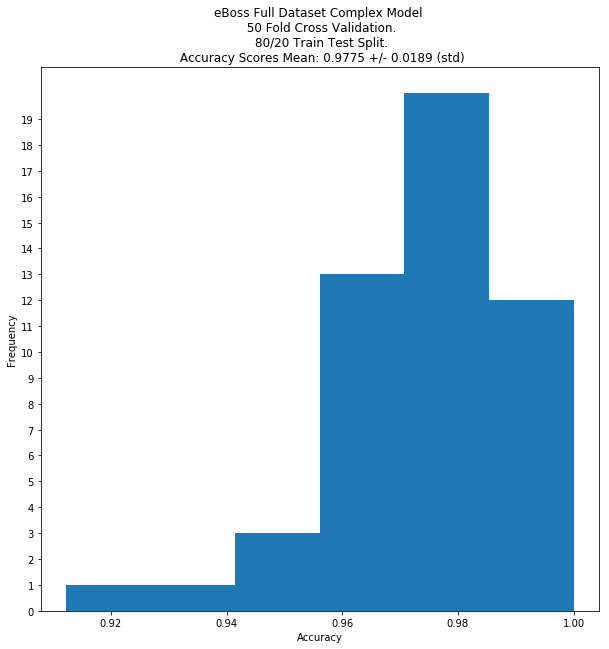

In [74]:
plt.figure(figsize=(10,10))
plt.title(f'eBoss Full Dataset Complex Model \n 50 Fold Cross Validation.\n 80/20 Train Test Split.\n Accuracy Scores Mean: {np.mean(v2_accuracy_list):0.4f} +/- {np.std(v2_accuracy_list):0.4f} (std)')
hist_values = plt.hist(v2_accuracy_list, bins=6)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.yticks(range(0,20))
plt.savefig('eBossFull50CrossValComplexModel.png')
plt.show()

### Running 50 folds on the simplier version of the nn model.

In [4]:
Keras_eboss_NN_Model = KerasClassifier(create_conv_flux_model, epochs=25, batch_size=8, verbose=0)
cvm_nn_flux = CrossValidationModeler(res_flux, Y, Keras_eboss_NN_Model)

In [ ]:
cvm_nn_flux.run_cross_val({}, n_splits=50)

Fitting 50 folds for each of 1 candidates, totalling 50 fits
[CV]  ................................................................
[CV]  , precision (no)=0.8095238095238095, precision (yes)=1.0, recall (no)=1.0, recall (yes)=0.9, accuracy=0.9298245614035088, roc_auc=0.95, f1=0.9473684210526316, total=   6.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.7s remaining:    0.0s


[CV]  , precision (no)=0.8, precision (yes)=1.0, recall (no)=1.0, recall (yes)=0.9333333333333333, accuracy=0.9473684210526315, roc_auc=0.9666666666666667, f1=0.9655172413793104, total=   4.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.4s remaining:    0.0s


[CV]  , precision (no)=1.0, precision (yes)=0.9523809523809523, recall (no)=0.8823529411764706, recall (yes)=1.0, accuracy=0.9649122807017544, roc_auc=0.9411764705882353, f1=0.975609756097561, total=   4.9s
[CV]  ................................................................
[CV]  , precision (no)=1.0, precision (yes)=0.9777777777777777, recall (no)=0.9230769230769231, recall (yes)=1.0, accuracy=0.9824561403508771, roc_auc=0.9615384615384616, f1=0.9887640449438202, total=   4.8s
[CV]  ................................................................
[CV]  , precision (no)=1.0, precision (yes)=0.95, recall (no)=0.8947368421052632, recall (yes)=1.0, accuracy=0.9649122807017544, roc_auc=0.9473684210526316, f1=0.9743589743589743, total=   5.0s
[CV]  ................................................................
[CV]  , precision (no)=1.0, precision (yes)=1.0, recall (no)=1.0, recall (yes)=1.0, accuracy=1.0, roc_auc=1.0, f1=1.0, total=   5.1s
[CV]  .......................................

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  5.7min finished


# Generating Cross Val Figure

In [7]:
pd.DataFrame(cvm_nn_flux.last_results).to_csv("simple_model_results_with_dropout.csv")

In [5]:
results = pd.read_csv('simple_model_results_with_dropout.csv').to_dict()

In [11]:
list(filter(lambda x: 'mean' in x[0], results.items()))

[('mean_fit_time', {0: 6.105077514648437}),
 ('mean_score_time', {0: 0.6888788795471191}),
 ('mean_test_precision (no)', {0: 0.9237667049668598}),
 ('mean_test_precision (yes)', {0: 0.9854085168391852}),
 ('mean_test_recall (no)', {0: 0.9599819070678204}),
 ('mean_test_recall (yes)', {0: 0.9705872733547556}),
 ('mean_test_accuracy', {0: 0.9670175438596492}),
 ('mean_test_roc_auc', {0: 0.965284590211288}),
 ('mean_test_f1', {0: 0.9772367582610966})]

In [6]:
accuracy_list = list(map(lambda x: x[1][0], filter(lambda x: 'accuracy' in x[0] and 'split' in x[0] , results.items())))

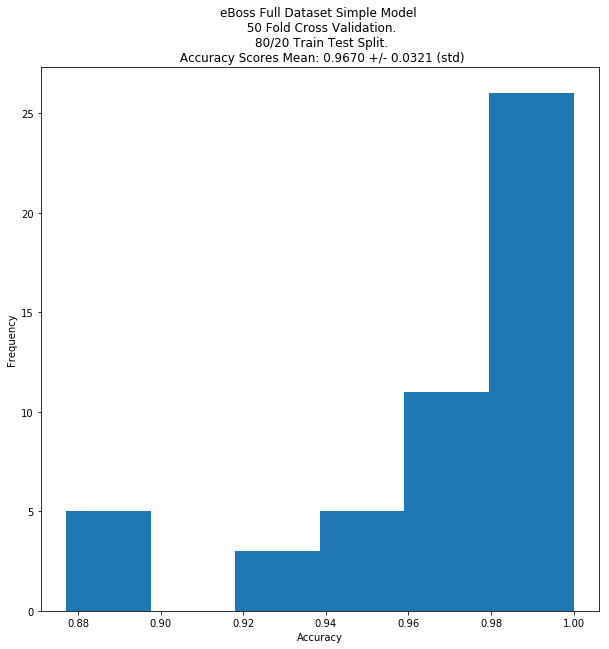

In [8]:
plt.figure(figsize=(10,10))
plt.title(f'eBoss Full Dataset Simple Model \n 50 Fold Cross Validation.\n 80/20 Train Test Split.\n Accuracy Scores Mean: {np.mean(accuracy_list):0.4f} +/- {np.std(accuracy_list):0.4f} (std)')
hist_values = plt.hist(accuracy_list, bins=6)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.savefig('eBossFull50CrossValSimpleModelwDropout.png')

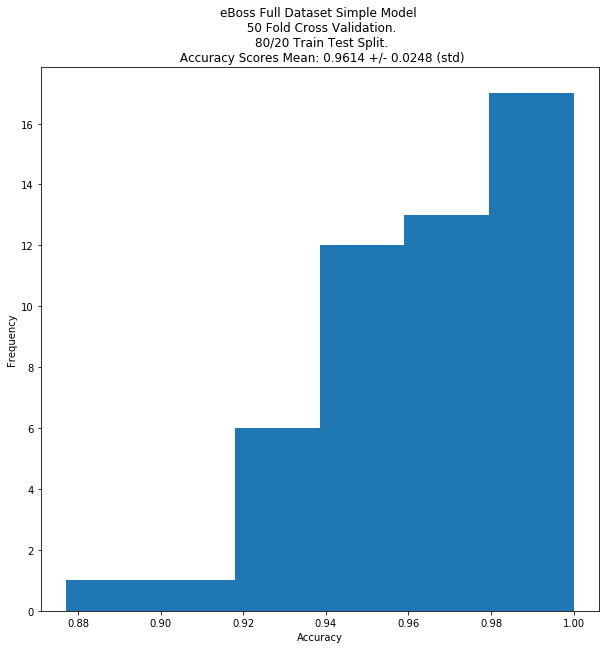

In [72]:
plt.figure(figsize=(10,10))
plt.title(f'eBoss Full Dataset Simple Model \n 50 Fold Cross Validation.\n 80/20 Train Test Split.\n Accuracy Scores Mean: {np.mean(accuracy_list):0.4f} +/- {np.std(accuracy_list):0.4f} (std)')
hist_values = plt.hist(accuracy_list, bins=6)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.savefig('eBossFull50CrossValSimpleModel.png')

---